<a href="https://colab.research.google.com/github/sagewoodard/SocialMediaBlocker-ChromeEXT/blob/main/GAN_11_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the dataset path
data_dir = '/content/drive/MyDrive/EuroSAT/Forest'

Mounted at /content/drive


In [ ]:
# Load the dataset as a TensorFlow Dataset
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import numpy as np

# Parameters for image preprocessing
IMG_SIZE = 64
BATCH_SIZE = 64 # Changed from 32 for stabilization
noise_dim = 100

# Load images from the directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    label_mode=None, # No labels are required for unsupervised learning
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Normalize images to [-1, 1], as required for GANs
train_dataset = train_dataset.map(lambda x: (x / 127.5) - 1)
train_dataset = train_dataset.shuffle(buffer_size=1000)

Found 3000 files.


In [ ]:
# Define the generator model
def build_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))
  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  return model

In [ ]:
# Define the discriminator model
def build_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMG_SIZE, IMG_SIZE, 3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

In [ ]:
# FID calculation functions
def calculate_fid(real_images, generated_images):
    # Resize images to match the InceptionV3 input requirements
    real_images_resized = tf.image.resize(real_images, (75, 75))
    generated_images_resized = tf.image.resize(generated_images, (75, 75))

    # Load the InceptionV3 model for feature extraction
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))

    # Preprocess images for InceptionV3
    real_images_resized = preprocess_input((real_images_resized + 1) * 127.5)  # Rescale to [0, 255]
    generated_images_resized = preprocess_input((generated_images_resized + 1) * 127.5)

    # Extract features using the InceptionV3 model
    act1 = inception_model.predict(real_images_resized)
    act2 = inception_model.predict(generated_images_resized)

    # Calculate the mean and covariance of the features
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)

    # Calculate the squared difference between the means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Calculate the square root of the product of the covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Handle numerical issues with complex numbers
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate the final FID score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
# Define the gradient penalty function
def gradient_penalty(discriminator, real_images, fake_images):
  # Dynamically adjust the alpha to match the batch size of real_image
  batch_size = tf.shape(real_images)[0]
  alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)

  # Explicitly reshape fake_images to match real_images
  fake_images = tf.reshape(fake_images, tf.shape(real_images))

  # Compute interpolated images
  interpolated = alpha * real_images + (1 - alpha) * fake_images

  with tf.GradientTape() as tape:
    tape.watch(interpolated)
    pred = discriminator(interpolated)

  grads = tape.gradient(pred, [interpolated])[0]
  norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
  penalty = tf.reduce_mean((norm - 1.0) ** 2)
  return penalty

In [ ]:
# Define the training loop with loss tracking
generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5, beta_2=0.9, clipnorm=1.0)

EPOCHS = 100 ##CHANGE##

# Define the number of disciminator steps per generator step
n_critic = 3 # Initial value
increase_n_critic = -30 # Threshold for discriminator loss
decrease_n_critic = -15 # Threshold for generator loss

# Lists to track losses
gen_losses = []
disc_losses = []

# Define the training step
def train_step(images, update_discriminator=True, update_generator=True):

  # Dynamically set batch size to match 'images'
  batch_size = tf.shape(images)[0]
  noise = tf.random.normal([batch_size, noise_dim], mean = 0.0, stddev=1.5) # Increase noise variance

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    # Apply label smoothings
    real_labels = tf.ones_like(real_output) * 0.9 # Label smoothing
    fake_labels = tf.zeros_like(fake_output)

    # Generator loss
    gen_loss = -tf.reduce_mean(fake_output)
    disc_loss = -tf.reduce_mean(real_output) + tf.reduce_mean(fake_output)

    # Add gradient penalty to discriminator loss
    penalty = gradient_penalty(discriminator, images, generated_images)
    disc_loss += 5.0 * penalty # Adjust lambda as needed

  # Apply gradients conditionally
  if update_discriminator:
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  if update_generator:
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  # Print losses for each batch
  print(f"Batch Generator Loss: {gen_loss.numpy()}, Batch Discriminator Loss: {disc_loss.numpy()}")

  return gen_loss, disc_loss

# Define the main training loop
def train(dataset, epochs):
  for epoch in range(epochs):
    epoch_gen_loss = 0.0
    epoch_disc_loss = 0.0
    batch_count = 0

    for image_batch in dataset:
      # Update the discriminator 'n_critic' times
      for _ in range(n_critic):
        disc_loss, _ = train_step(image_batch, update_discriminator=True, update_generator=False)
        disc_losses.append(disc_loss.numpy())  # Append discriminator loss to list
        epoch_disc_loss += disc_loss.numpy()

      # Update the generator once after 'n_critic' discriminator updates
      gen_loss, disc_loss = train_step(image_batch)
      gen_losses.append(gen_loss.numpy())  # Append generator loss to list
      disc_losses.append(disc_loss.numpy())  # Append discriminator loss to list

      epoch_gen_loss += gen_loss.numpy()
      epoch_disc_loss += disc_loss.numpy()
      batch_count += 1

    # Calculate average losses for the epoch
    avg_gen_loss = epoch_gen_loss / batch_count
    avg_disc_loss = epoch_disc_loss / batch_count

    print(f"Epoch {epoch + 1}/{epochs} completed")
    print(f"Epoch {epoch + 1}/{epochs} - Average Generator Loss: {avg_gen_loss}, Average Discriminator Loss: {avg_disc_loss}")

  # FID calculation at the end
  real_images = next(iter(dataset))
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  generated_images = generator(noise, training=False)
  fid_score = calculate_fid(real_images[:BATCH_SIZE], generated_images)
  print(f"Final FID: {fid_score}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
train(train_dataset, EPOCHS)

Streaming output truncated to the last 5000 lines.
Batch Generator Loss: -9.895933151245117, Batch Discriminator Loss: -0.4302285611629486
Batch Generator Loss: -9.314327239990234, Batch Discriminator Loss: 0.1967274248600006
Batch Generator Loss: -5.122226715087891, Batch Discriminator Loss: -0.8098190426826477
Batch Generator Loss: -0.3026498556137085, Batch Discriminator Loss: -1.2569077014923096
Batch Generator Loss: 4.4931135177612305, Batch Discriminator Loss: -1.1857597827911377
Batch Generator Loss: 7.517308235168457, Batch Discriminator Loss: -0.22900453209877014
Batch Generator Loss: 10.318049430847168, Batch Discriminator Loss: -0.22014278173446655
Batch Generator Loss: 13.913724899291992, Batch Discriminator Loss: -0.35262811183929443
Batch Generator Loss: 18.813705444335938, Batch Discriminator Loss: -1.3549846410751343
Batch Generator Loss: 22.942577362060547, Batch Discriminator Loss: 0.015850748866796494
Batch Generator Loss: 26.568531036376953, Batch Discriminator Loss

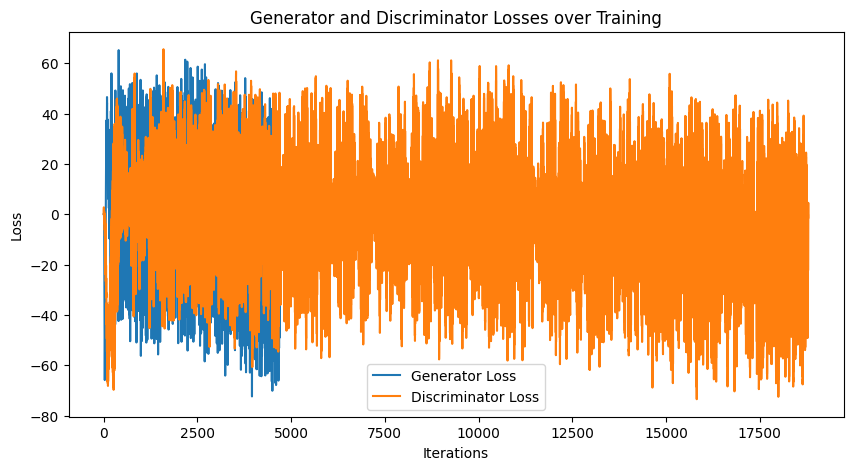

In [ ]:
# Plot the generator and discriminator losses

def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Generator and Discriminator Losses over Training")
    plt.show()

# Plot the loss curves after training
plot_losses(gen_losses, disc_losses)

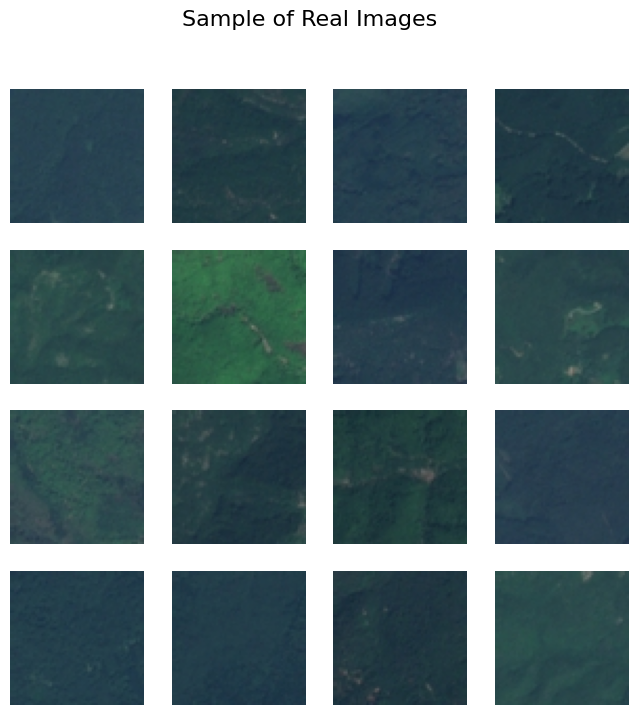

In [ ]:
# Display a sample of real images
def show_real_images(dataset, num_images=16):
    real_images = next(iter(dataset))[:num_images]  # Take a batch of images
    real_images = (real_images + 1) / 2.0  # Rescale to [0, 1] for display

    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(real_images[i])
        plt.axis("off")
    plt.suptitle("Sample of Real Images", fontsize=16)
    plt.show()

show_real_images(train_dataset)

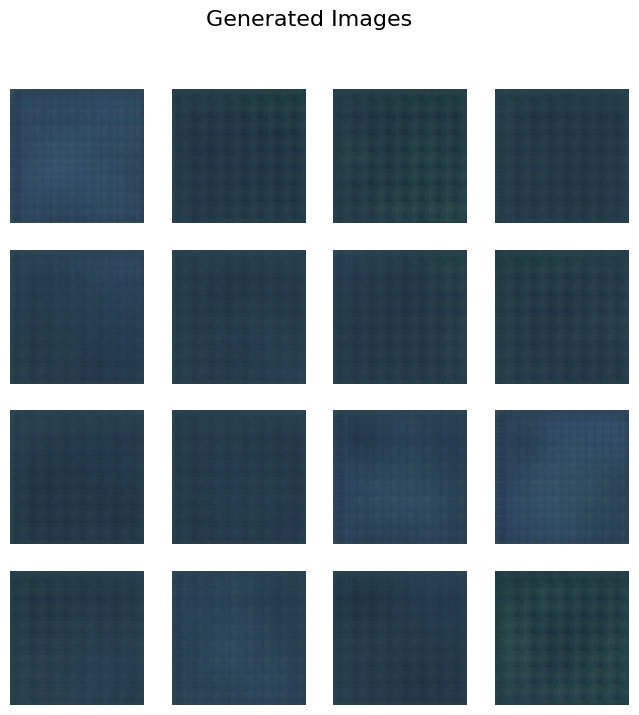

In [ ]:
# Display a sample of generated images
def generate_and_show_images(generator, noise_dim, num_images=16):
    noise = tf.random.normal([num_images, noise_dim])
    generated_images = generator(noise, training=False)
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1] for display

    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.suptitle("Generated Images", fontsize=16)
    plt.show()

generate_and_show_images(generator, noise_dim)